# Исследование объявлений о продаже квартир

Датасет — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.  
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных (расстояние до центра, аэропорта, ближайшего парка и водоёма).  

Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

### Оглавление

[1. Открытие и изучение данных](#1)  
[2. Предобработка данных](#2)  
[3. Расчеты](#3)  
[4. Исследвательский анализ данных](#4)  
[5. Общий вывод](#5)

### 1. Открытие и изучение данных<a id='1'></a>

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t', decimal='.')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

В таблице 22 колонки с различными типами данных. Имеются пропущенные значения.

### 2. Предобработка данных<a id='2'></a>

Число пропущенных значений

In [38]:
df.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

ceiling_height, living_area, is_apartment, kitchen_area, balcony, locality_name данные от владельцев недвижимости.  
Возможно, владельцы расчитывают прежде всего на личный разговор с потенциальным покупателем, чтобы сообщить недостающую информацию, если она нужна. Также в описании квартиры вместо точного указания, например, высоты потолков, могли написать "потолки высокие", но это не информативно. locality_name скорее всего владельцы оставили, но это мог быть не конкретный населенный пункт, а область. При выгрузке данных эта информация не отбразилась, либо возникла другая ошибка.

airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition заполнены автоматически.  
Пропуски в days_exposition связаны с отсутствием информации о дате снятия объявления. Вариантов может быть несколько, например:  
- продавец не сам отметил продажу, а это сделал потенциальный клиент или менеджер, который узнал о неактуальности объявления, в этом случае точная дата неизвестна;  
- срок объявления истек, дату продажи указать забыли.  

Пропуски, основанные на картах, могут быть связаны с отсутствием информации по конкретному населенному пункту. Проверим на примере городского посёлока Янино-1.

In [39]:
df[df['locality_name'] == 'городской посёлок Янино-1'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61 entries, 5 to 23390
Data columns (total 22 columns):
total_images            61 non-null int64
last_price              61 non-null float64
total_area              61 non-null float64
first_day_exposition    61 non-null object
rooms                   61 non-null int64
ceiling_height          25 non-null float64
floors_total            61 non-null float64
living_area             57 non-null float64
floor                   61 non-null int64
is_apartment            0 non-null object
studio                  61 non-null bool
open_plan               61 non-null bool
kitchen_area            53 non-null float64
balcony                 24 non-null float64
locality_name           61 non-null object
airports_nearest        0 non-null float64
cityCenters_nearest     0 non-null float64
parks_around3000        0 non-null float64
parks_nearest           0 non-null float64
ponds_around3000        0 non-null float64
ponds_nearest           0 non-null 

Видно, что из 61 объявления нет ни одного автоматического заполнения на основе карты. Значит действительно нет информации по некоторым населенным пунктам. Дополнительные пропуски в "картографических" колонках могут быть связаны с отсутствием объекта (водоёма или парка).

### Работа с пропусками

В массовых застройках стандарты по высоте потолков примерно одинаковые. Исключим ошибки смещения целой доли. Найдем потолки выше 20 метров и заменим значения близкие к стандартам.

In [40]:
print(df[df['ceiling_height'] >= 20]['ceiling_height'].value_counts())
df['ceiling_height'].update(df[df['ceiling_height'] >= 20]['ceiling_height'] / 10)
print(df[df['ceiling_height'] >= 20]['ceiling_height'].count())

27.0     8
25.0     7
32.0     2
22.6     1
100.0    1
27.5     1
20.0     1
26.0     1
24.0     1
Name: ceiling_height, dtype: int64
0


Найдем медианы высоты по этажности дома.

In [41]:
median_ceiling_height = df.groupby('floors_total')['ceiling_height'].median().to_frame()
median_ceiling_height.loc[33] = median_ceiling_height.loc[34]
median_ceiling_height

,ceiling_height
floors_total,
1.0,2.80
2.0,2.70
3.0,2.80
4.0,3.00
5.0,2.55
6.0,3.00
7.0,3.00
8.0,2.80
9.0,2.55


Пропуски в колонке ceiling_height заменим на медианы.

In [42]:
print(df['ceiling_height'].isnull().sum())

for floor in median_ceiling_height.index:
    
    df['ceiling_height'].update(df[
        (df['ceiling_height'].isnull()) & 
        (df['floors_total'] == floor)
    ]['ceiling_height'].fillna(median_ceiling_height.loc[floor]['ceiling_height']))
        
print(df['ceiling_height'].isnull().sum())

9195
77


Оставшиеся пропуски связаны с отсутствием информации в floors_total

In [43]:
df[df['ceiling_height'].isnull()]['floors_total'].isnull().sum()

77

Пропуски в колонке balcony заменим на 0. Потому что, если человек не указал количество балконов, то скорее всего они отсутсвуют.

In [44]:
df['balcony'] = df['balcony'].fillna(0)
df['balcony'].isnull().sum()

0

Пропуски в колонке is_apartment заменим на False. Потому что, апартаменты другая форма собственности, и эту информацию скорее всего могут не заполнить только по квартирам.

In [45]:
df['is_apartment'] = df['is_apartment'].fillna(False)
df['is_apartment'].isnull().sum()

0

Изменим тип данных в колонке last_price на int, потому что, когда продают за миллионы, до копеек не торгуются.

In [46]:
df['last_price'] = df['last_price'].astype(int)

Изменим тип данных в колонке first_day_exposition datetime, чтобы дальше работать с информацией как с датой.

In [47]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Количество балконов - целое число, поэтому приведем к int.

In [48]:
df['balcony'] = df['balcony'].astype(int)

Аппартаменты имеет значения True и False, поэтому дальше будем работать с типом bool.

In [49]:
df['is_apartment'] = df['is_apartment'].astype(bool)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null int64
total_area              23699 non-null float64
first_day_exposition    23699 non-null datetime64[ns]
rooms                   23699 non-null int64
ceiling_height          23622 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            23699 non-null bool
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 23699 non-null int64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around

Проверим наличие дубликатов.

In [51]:
df.duplicated().sum()

0

Проверим колонку rooms

In [52]:
df['rooms'].value_counts()

1     8047
2     7940
3     5814
4     1180
5      326
0      197
6      105
7       59
8       12
9        8
10       3
14       2
11       2
19       1
12       1
16       1
15       1
Name: rooms, dtype: int64

Будем считать, что в студии комнат нет, поэтому заменим в студиях значение на 0.

In [53]:
print(len(df[(df['studio'] == True) & (df['rooms'] == 0)]))
df['rooms'].update(df[df['studio'] == True]['rooms'].replace(1,0))
print(len(df[(df['studio'] == True) & (df['rooms'] == 0)]))

138
149


Для квартир расчитаем медиану площади квартиры в зависимости от количества комнат.

In [54]:
median_total = df[df['studio'] == False].pivot_table(index='rooms', values='total_area', aggfunc='median').drop(0).reset_index()
median_total

,rooms,total_area
0,1,36.60
1,2,53.00
2,3,73.00
3,4,99.30
4,5,146.45
5,6,184.30
6,7,214.00
7,8,235.70
8,9,300.95
9,10,272.60


Посмотрим какие максимальные значения нужно заменить.

In [55]:
data_need_change = df.loc[(df['studio'] == False) & (df['rooms'] == 0)]
data_need_change['total_area'].sort_values(ascending=False)

19392    371.00
7237      42.63
839       35.00
4683      35.00
508       34.40
21628     34.00
7008      32.30
17805     31.10
6805      31.00
19735     30.50
7286      30.00
18549     29.00
23592     29.00
21299     28.50
9586      28.30
13953     28.20
17729     28.05
16429     28.01
6472      28.00
20002     28.00
23442     27.70
20793     27.50
11331     27.32
7818      27.30
11157     27.30
2532      27.10
12412     27.00
15434     27.00
6612      26.80
15105     26.10
780       26.10
11035     26.00
11051     26.00
11705     26.00
18042     25.90
19917     25.41
10606     25.27
15273     25.20
4437      25.00
20045     25.00
4876      25.00
5749      25.00
18782     25.00
9861      25.00
349       25.00
12691     24.20
17695     24.00
10284     24.00
4115      24.00
3019      24.00
22573     24.00
1625      23.98
11692     23.06
946       23.00
17824     22.50
1574      22.00
20054     21.00
19477     20.00
9412      16.00
Name: total_area, dtype: float64

In [56]:
df['rooms'].value_counts()

1     8036
2     7940
3     5814
4     1180
5      326
0      208
6      105
7       59
8       12
9        8
10       3
14       2
11       2
19       1
12       1
16       1
15       1
Name: rooms, dtype: int64

Медианные значения площади увеличиваются пропорционально числу комнат до 146.45 м (5 комнат), затем зависимость теряется. У нас есть одно значение, которое явно выбивается от остальных - 371. Так как основное количество объявлений размещается по недвижимости с не более 5 комнатами, то нам важен сам факт наличия более 5 комнат, а не точное число.

Заменим значение комнат с 0 в квартирах согласно медиане площади квартиры

In [57]:
print(len(df[(df['studio'] == False) & (df['rooms'] == 0)]))

for index in median_total.index:
    data_need_change['rooms'].update(
        data_need_change[
            data_need_change['total_area'] <= median_total.loc[index,'total_area']
        ]['rooms'].replace(0, median_total.loc[index,'rooms'])
    )
df['rooms'].update(data_need_change['rooms'])    
    
print(len(df[(df['studio'] == False) & (df['rooms'] == 0)]))
print(df[df['total_area'] == 371]['rooms']) 

59
0
19392    12
Name: rooms, dtype: int64


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3319: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

Проверка

In [58]:
print(len(df[df['studio'] == True]))
print(len(df[df['rooms'] == 0]))

149
149


### Вывод

Пропуски были заполнены в двух колонках (balcony, is_apartment). В других колонках пропуски остались так как для заполнения не хватает данных, а с удалением потеряем нужные данные. Дубликаты не выявлены. Все студии имеют 0 комнат.

### 3. Расчеты <a id='3'></a>

Посчитаем цену квадратного метра.

In [59]:
df['price_square_meter'] = (df['last_price'] / df['total_area']).round(3)

Найдем день недели, месяц и год публикации объявления.

In [60]:
df['weekday_exposition'] = df['first_day_exposition'].dt.weekday
df['month_exposition'] = pd.DatetimeIndex(df['first_day_exposition']).month
df['year_exposition'] = pd.DatetimeIndex(df['first_day_exposition']).year

Определим этаж квартиры в доме.

In [61]:
floor_list = []
null_in_floors_total = df['floors_total'].isnull()

for el in df.index:
    if df.loc[el,'floor'] == 1:
        floor_list.append('первый')
    elif df.loc[el,'floor'] == df.loc[el,'floors_total']:
        floor_list.append('последний')
    elif null_in_floors_total[el] is True:
        floor_list.append('NaN')
    else:
        floor_list.append('другой')

df['floor_in_house'] = floor_list
df[df['floors_total'].isnull()].head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,weekday_exposition,month_exposition,year_exposition,floor_in_house
186,12,11640000,65.2,2018-10-02,2,NaN,NaN,30.80,4,False,...,1.0,123.0,0.0,NaN,49.0,178527.607,1,10,2018,другой
237,4,2438033,28.1,2016-11-23,1,NaN,NaN,20.75,1,False,...,0.0,NaN,1.0,374.0,251.0,86762.740,2,11,2016,первый
457,4,9788348,70.8,2015-08-01,2,NaN,NaN,38.40,12,False,...,2.0,309.0,2.0,706.0,727.0,138253.503,5,8,2015,другой
671,4,6051191,93.6,2017-04-06,3,NaN,NaN,47.10,8,False,...,0.0,NaN,1.0,374.0,123.0,64649.476,3,4,2017,другой
1757,5,3600000,39.0,2017-04-22,1,NaN,NaN,NaN,9,False,...,1.0,835.0,1.0,652.0,77.0,92307.692,5,4,2017,другой


Определим соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [62]:
df['living/total'] = (df['living_area'] / df['total_area']).round(3)
df['kitchen/total'] = (df['kitchen_area'] / df['total_area']).round(3)
df.loc[:,['living/total','kitchen/total']].head(5)

,living/total,kitchen/total
0,0.472,0.231
1,0.460,0.272
2,0.612,0.148
3,NaN,NaN
4,0.320,0.410


### Вывод

Было добавлено 8 колонок. Некоторые из них содержат пропущенные значения так как расчеты производились с колонками с пропусками.

### 4. Исследовательский анализ данных <a id='4'></a>

Изучим следующие параметры: площадь, цена, число комнат, высота потолков. Построим гистограммы для каждого параметра.

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64


Text(0.5, 0, 'total_area')

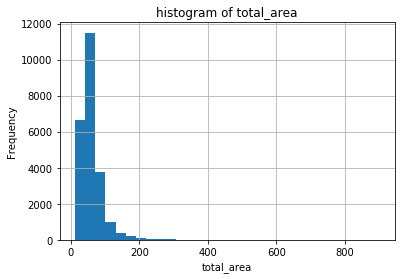

In [63]:
print(df['total_area'].describe())
df['total_area'].plot(kind='hist', bins=30, title='histogram of total_area', grid=True).set_xlabel('total_area')

Наблюдаем распределение Пуассона с пиком на 40-70 метрах, недвижимость с площадью больше 170 м почти не продается. Медиана меньше среднего, что говорит о влиянии на него аномальных значений. 

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64


Text(0.5, 0, 'last_price')

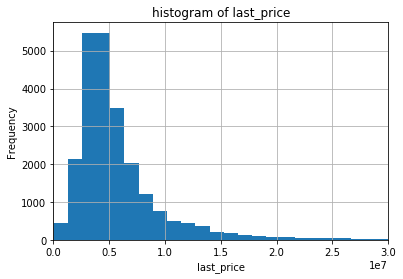

In [64]:
print(df['last_price'].describe())
df['last_price'].plot(
    kind='hist', bins=600, title='histogram of last_price', xlim=(0,30000000), grid=True
).set_xlabel('last_price')

Наблюдаем распределение Пуассона с пиком на 3-5 млн, недвижимость дороже 12 млн продавалась редко. Медиана значительно меньше среднего, что говорит о влиянии на него аномальных значений. Минимальное значение в 12190 тоже является скорее аномальным значением. Таким образом, аномальные значения есть с двух сторон, но количество правых больше.

count    23699.000000
mean         2.073168
std          1.077336
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64


Text(0.5, 0, 'rooms')

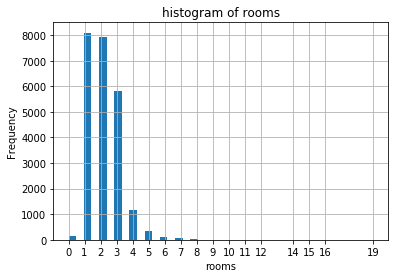

In [65]:
print(df['rooms'].describe())
df['rooms'].plot(
    kind='hist', bins=40, title='histogram of rooms', grid=True, xticks=df['rooms'].unique()
).set_xlabel('rooms')

Наблюдаем распределение Пуассона с пиком на 1-2 комнатах, объявления с 6 комнатами и более выставляются редко. Медиана почти совпадает со средним, значит аномальные значения единичны. 

count    23622.000000
mean         2.709694
std          0.265594
min          1.000000
25%          2.550000
50%          2.650000
75%          2.750000
max         14.000000
Name: ceiling_height, dtype: float64


Text(0.5, 0, 'ceiling_height')

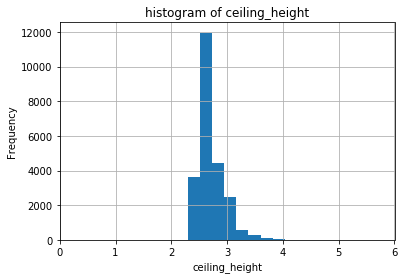

In [66]:
print(df['ceiling_height'].describe())
df['ceiling_height'].plot(
    kind='hist', bins=60, title='histogram of ceiling_height', grid=True, xlim=(0,6)
).set_xlabel('ceiling_height')

Наблюдаем распределение Пуассона с пиком около 2.6 м, потолки выше 3.2 м почти не встречаются. Медиана примерно равна среднему. Аномальные значения есть с двух сторон, но малом количестве.

Изучим время продажи квартиры. 

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64
45.0    880
60.0    538
7.0     234
30.0    208
90.0    204
       ... 
78.0     51
94.0     49
87.0     43
2.0       3
1.0       1
Name: days_exposition, Length: 99, dtype: int64


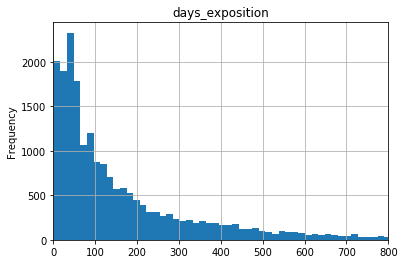

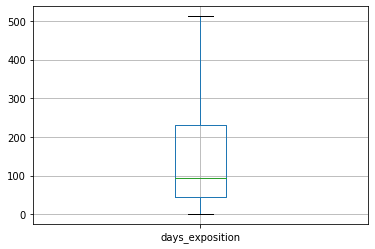

In [67]:
print(df['days_exposition'].describe())
df['days_exposition'].plot(kind='hist', bins=100, title='days_exposition', grid=True, xlim=(0,800))
print(df[df['days_exposition'] < 100]['days_exposition'].value_counts())
plt.show()
df.boxplot('days_exposition', showfliers=False)

Чаще всего недвижимость продавали за 45 дней, 50% продаж совершили за 45-232 дня. Медиана почти в два раза меньше среднего значения из-за высоких аномальных значений. Аномальные значения начинаются с 513 дней и доходят до 1580.  
Получается, что до 45 дней - очень быстрая продажа, 45-232 дня - нормальная продажа, и больше 232 дней - необычно долгая продажа.

Уберем редкие и выбивающиеся значения. Дольше 600 дней квартиры продаются редко. Надо полагать, что, если квартира долго не продается, то цена завышена, а для анализа цен нам нужны цены соответствующие рынку.

In [68]:
df[df['days_exposition'] > 600]['days_exposition'].count()

1198

In [69]:
index_drop = df[df['days_exposition'] > 600].index
df = df.drop(index_drop).reset_index(drop=True)
df[df['days_exposition'] > 600]['days_exposition'].count()

0

In [70]:
df['days_exposition'].describe()

count    19320.000000
mean       139.175311
std        137.007986
min          1.000000
25%         42.000000
50%         89.000000
75%        195.000000
max        600.000000
Name: days_exposition, dtype: float64

Среднее значение, как и стандартное отклонение, значительно упало, но все равно сильно отличается от медианы. 

Изучим, зависит ли цена от площади, числа комнат, удалённости от центра, от того, на каком этаже расположена квартира и от даты размещения объявления.

In [71]:
list_series = ['total_area','rooms','cityCenters_nearest', 'weekday_exposition', 'month_exposition', 'year_exposition']
for el in list_series:
    print('Корреляция last_price от {}: {:.3f}'.format(el,df['last_price'].corr(df[el])))

Корреляция last_price от total_area: 0.647
Корреляция last_price от rooms: 0.360
Корреляция last_price от cityCenters_nearest: -0.202
Корреляция last_price от weekday_exposition: 0.002
Корреляция last_price от month_exposition: 0.001
Корреляция last_price от year_exposition: -0.028


Получено следующее: 
- с total_area есть слабая прямая линейная зависимость, что логично, с увеличением площади квартиры естественно увеличивается и цена,
- с rooms наблюдается та же зависимость,
- с cityCenters_nearest есть слабая обратная линейная зависимость, если расстояние до центра уменьшается, то действительно увеличивается цена.
- с weekday_exposition, month_exposition, year_exposition линейная зависимость отсутствует

In [72]:
relation_floor_price = df.pivot_table(
    index='floor_in_house', 
    values='last_price', 
    aggfunc=['median']
)

relation_floor_price.columns = ['median_price']
relation_floor_price.style.format('{:.0f}')

,median_price
floor_in_house,
другой,4800000
первый,3900000
последний,4300000


Можно проследить зависимость цены от этажа квартиры. Так квартиры на первом этаже - самые дешевые, дороже идут квартиры на последнем этаже, и самые дорогие расположены на средних этажах.

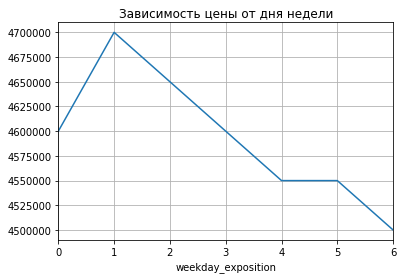

In [73]:
relation_weekday_price = (
    df.pivot_table(index='weekday_exposition', values='last_price', aggfunc=['median'])
)
relation_weekday_price.plot(grid=True, legend=False, title='Зависимость цены от дня недели')

Во вторник выставлились более дорогие квартиры, а в воскресенье - более дешевые. Но колебание цены ниже 5%.

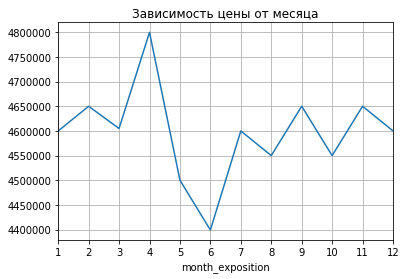

In [74]:
relation_month_price = (
    df.pivot_table(index='month_exposition', values='last_price', aggfunc=['median'])
)
relation_month_price.plot(grid=True,
                          legend=False, 
                          title='Зависимость цены от месяца', 
                          xticks=df['month_exposition'].unique()
                         )

С июля по март цены практически не меняются.  
В апреле цены выше средних на 4%.  
Затем до июня наблюдается спад. В июне, по сравнению с апрелем, цена меньше на 8%.

2018    8519
2017    8053
2019    2879
2016    2337
2015     667
2014      46
Name: year_exposition, dtype: int64
2019-05-03 00:00:00


,median
,last_price
year_exposition,
2014,9050000
2015,5100000
2016,4490000
2017,4500000
2018,4550000
2019,5050000


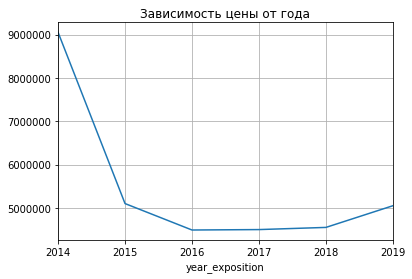

In [75]:
relation_year_price = (
    df.pivot_table(index='year_exposition', values='last_price', aggfunc=['median'])
)
relation_year_price.plot(grid=True, legend=False, title='Зависимость цены от года')
print(df['year_exposition'].value_counts())
print(df['first_day_exposition'].max())
relation_year_price

На графике виден значительный спад с 2014 года до 2016 года, который, возможно, связан с малым объемом выборки. C 2016 года до 2018 года цена оставалась примерно на одном уровне, а с 2018 по 2019 выросла на 10%, что, может быть, связано с меньшим временным интервалом (данные за 2019 год по май). 

Проверим наметившуюся тенденцию на графике на примерно равных по объему выборках.

In [76]:
print('Медиана 3 квартала 2015', df[(df['month_exposition'] > 8) & (df['year_exposition'] == 2015)]['last_price'].median())
print('Размер выборки', len(df[(df['month_exposition'] > 8) & (df['year_exposition'] == 2015)]))

print('Медиана 3 квартала 2016', df[(df['month_exposition'] > 8) & (df['year_exposition'] == 2016)]['last_price'].median())
print('Размер выборки', len(df[(df['month_exposition'] > 8) & (df['year_exposition'] == 2016)]))

Медиана 3 квартала 2015 4985000.0
Размер выборки 360
Медиана 3 квартала 2016 4500000.0
Размер выборки 394


В 2016 году цены были ниже чем в 2015.

In [77]:
print('Медиана 3 квартала 2018', df[(df['month_exposition'] > 8) & (df['year_exposition'] == 2018)]['last_price'].median())
print('Размер выборки', len(df[(df['month_exposition'] > 8) & (df['year_exposition'] == 2018)]))

print('Медиана 1 квартала 2019', df[df['year_exposition'] == 2019]['last_price'].median())
print('Размер выборки', len(df[df['year_exposition'] == 2019]))

Медиана 3 квартала 2018 4733000.0
Размер выборки 2888
Медиана 1 квартала 2019 5050000.0
Размер выборки 2879


Действительно в 2019 году цена на недвижимость выросла. Изменение цены с конца 2018 составило 6%.

Выберем 10 населённых пунктов с наибольшим числом объявлений и посчитаем среднюю цену квадратного метра.

In [78]:
popular_city = (df.groupby('locality_name')
    .agg({'price_square_meter': ['count','median']})
    .sort_values(by=('price_square_meter','count'), ascending=False)
    .head(10)
)
popular_city.columns = ['count','median']
popular_city.sort_values(by='median', ascending=False)

,count,median
locality_name,,
Санкт-Петербург,14881,104724.4090
Пушкин,349,99987.1790
деревня Кудрово,276,92044.8640
посёлок Парголово,318,91387.3625
посёлок Мурино,502,86076.8750
посёлок Шушары,426,76876.1725
Колпино,329,74468.0850
Гатчина,289,67796.6100
Всеволожск,377,65789.4740


Самая высокая стоимость жилья среди популярных населенных пунктов в Санкт-Петербурге, самая низкая - в Выборге.

Создадим столбец с расстоянием до центра в километрах.

In [79]:
df['distance to center'] = (df['cityCenters_nearest'] / 1000).round()
df['distance to center']

0        16.0
1        19.0
2        14.0
3         7.0
4         8.0
         ... 
22496    34.0
22497     4.0
22498     NaN
22499     NaN
22500     NaN
Name: distance to center, Length: 22501, dtype: float64

По зависимости средней цены от расстояния выделим центр.

,price_square_meter
distance to center,
0.0,150243.9685
1.0,127586.1340
2.0,123966.9420
3.0,110013.9275
4.0,119420.9040
5.0,126834.8130
6.0,131795.4550
7.0,126063.8300
8.0,122944.9290


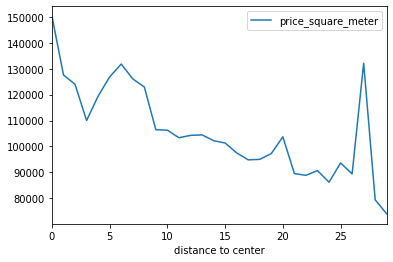

In [80]:
price_from_km = (df[df['locality_name'] == 'Санкт-Петербург']
     .pivot_table(index='distance to center', 
                  values='price_square_meter', 
                  aggfunc='median')
)
price_from_km.plot()
price_from_km

В левой части графика выделяются два пика с самыми высокими ценами. Далее цена постепенно идет на убывание до правых пиков, которые могут быть связаны с дорогой застройкой в отдельных районах вне центра. Будем считать резкий спад до 9 км границей центра.

Изучим следующие параметры: площадь, цена, число комнат, высота потолков. И сравним графики с предыдущими.

count    3764.000000
mean       89.189902
std        58.483136
min        12.000000
25%        54.000000
50%        75.200000
75%       105.000000
max       900.000000
Name: total_area, dtype: float64


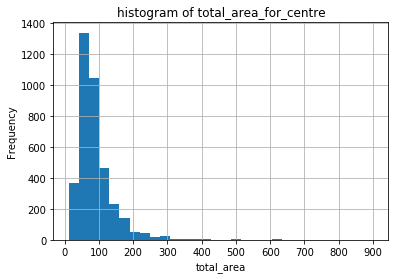

Text(0.5, 0, 'total_area')

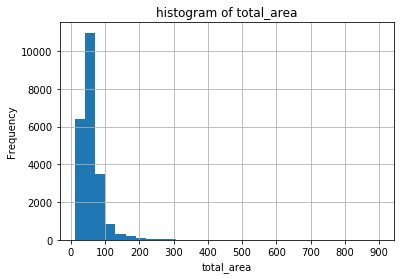

In [81]:
df_centre = df[df['distance to center'] < 9]
print(df_centre['total_area'].describe())

df_centre['total_area'].plot(
    kind='hist', bins=30, title='histogram of total_area_for_centre', grid=True, xticks=range(0,901,100)
).set_xlabel('total_area')
plt.show()
df['total_area'].plot(
    kind='hist', bins=30, title='histogram of total_area', grid=True, xticks=range(0,901,100)
).set_xlabel('total_area')

График похож на аналогичный для всей выборки. Чаще всего продают квартиры с площадью от 40 до 70 метров. Основная разница - меньшее количество квартир с площадью до 40 метров в центре и большее от 70 до 100. 

count    3.764000e+03
mean     1.401513e+07
std      2.387263e+07
min      1.600000e+06
25%      6.376250e+06
50%      8.845000e+06
75%      1.380000e+07
max      7.630000e+08
Name: last_price, dtype: float64


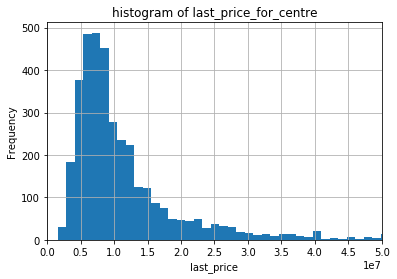

Text(0.5, 0, 'last_price')

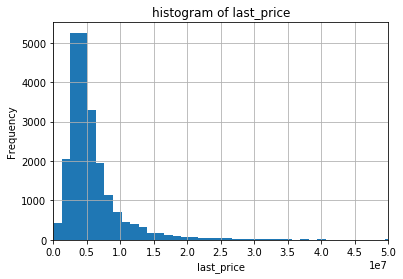

In [82]:
print(df_centre['last_price'].describe())

df_centre['last_price'].plot(kind='hist', 
                             bins=600, 
                             title='histogram of last_price_for_centre', 
                             xlim=(0,50000000), 
                             grid=True, 
                             xticks=range(0,60000000,5000000)
                            ).set_xlabel('last_price')
plt.show()
df['last_price'].plot(kind='hist', 
                      bins=600, 
                      title='histogram of last_price', 
                      xlim=(0,50000000), 
                      grid=True, 
                      xticks=range(0,60000000,5000000)
                     ).set_xlabel('last_price')

Если данные по всей выборке с пиком на 3-5 млн, то по данным с центром города весь график смещен вправо, и пик начинается выше 5 млн. Квартиры, определенно, в центре дороже.

count    3764.000000
mean        2.732997
std         1.406740
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max        19.000000
Name: rooms, dtype: float64


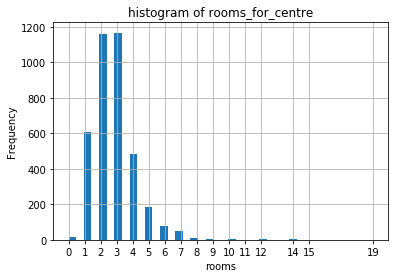

Text(0.5, 0, 'rooms')

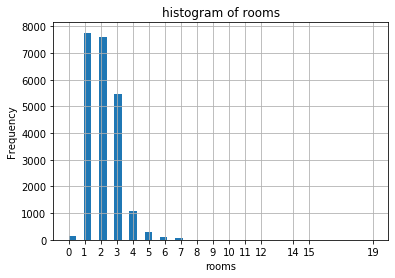

In [83]:
print(df_centre['rooms'].describe())

df_centre['rooms'].plot(
    kind='hist', bins=40, title='histogram of rooms_for_centre', grid=True, xticks=df_centre['rooms'].unique()
).set_xlabel('rooms')
plt.show()
df['rooms'].plot(
    kind='hist', bins=40, title='histogram of rooms', grid=True, xticks=df['rooms'].unique()
).set_xlabel('rooms')

В центре прослеживается интерес к большему количеству комнат. Квартиры с 3 комнатами продают также часто, как и с 2, а вот квартиры с 1 комнатой намного реже.  

count    3757.000000
mean        2.945930
std         0.371517
min         2.000000
25%         2.700000
50%         3.000000
75%         3.100000
max        10.000000
Name: ceiling_height, dtype: float64


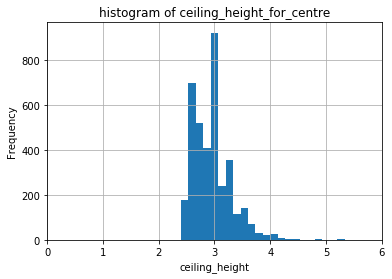

Text(0.5, 0, 'ceiling_height')

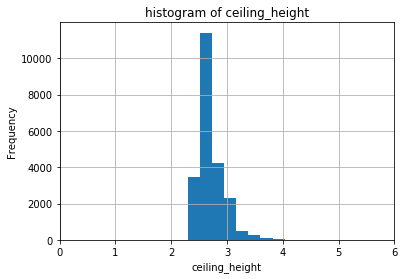

In [84]:
print(df_centre['ceiling_height'].describe())

df_centre['ceiling_height'].plot(
    kind='hist', bins=60, title='histogram of ceiling_height_for_centre', grid=True, xlim=(0,6)
).set_xlabel('ceiling_height')
plt.show()
df['ceiling_height'].plot(
    kind='hist', bins=60, title='histogram of ceiling_height', grid=True, xlim=(0,6)
).set_xlabel('ceiling_height')

Если по всем данным пик наблюдается около 2.6 м, а потолки выше 3.2 м почти не встречаются. То в центре наблюдается несколько пиков и самый явный около 3 м, видно, что потолки здесь выше.

Выделим факторы, которые влияют на стоимость квартиры.

In [85]:
list_series = ['total_area','rooms', 'cityCenters_nearest']
for el in list_series:
    print('Корреляция last_price от {}: {:.3f}'.format(el,df_centre['last_price'].corr(df_centre[el])))

Корреляция last_price от total_area: 0.634
Корреляция last_price от rooms: 0.345
Корреляция last_price от cityCenters_nearest: -0.080


Коэффициенты Пирсона от общих данных и от данных по центру примерно равны. Зависимость есть.  
Зависимость от расстояния отсутствует, значит выбранная территория относится к центру.

In [86]:
relation_floor_price_for_centre = (
    df_centre.pivot_table(index='floor_in_house', values='last_price', aggfunc=['median'])
)

relation_floor_price_for_centre.columns = ['median_price']
relation_floor_price_for_centre.style.format('{:.0f}')

,median_price
floor_in_house,
другой,9200000
первый,6350000
последний,8945000


Результат совпадает с предыдущим. Квартиры на первом этаже - самые дешевые, дороже идут квартиры на последнем этаже, и самые дорогие расположены на средних этажах.

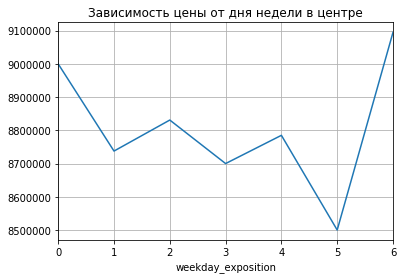

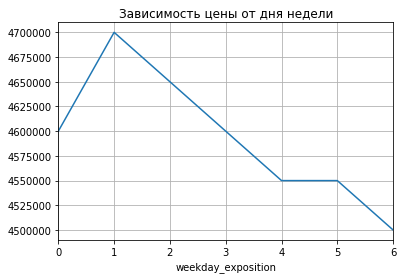

In [87]:
relation_weekday_price_for_centre = (
    df_centre.pivot_table(index='weekday_exposition', values='last_price', aggfunc=['median'])
)
relation_weekday_price_for_centre.plot(grid=True, legend=False, title='Зависимость цены от дня недели в центре')
relation_weekday_price.plot(grid=True, legend=False, title='Зависимость цены от дня недели')


Графики противоречат друг другу. Зависимость не наблюдается.

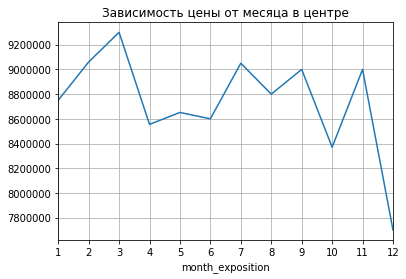

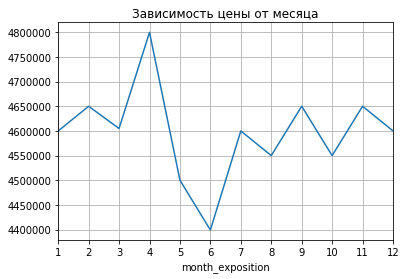

In [88]:
relation_month_price_for_centre = (
    df_centre.pivot_table(index='month_exposition', values='last_price', aggfunc=['median'])
)
relation_month_price_for_centre.plot(grid=True,
                          legend=False, 
                          title='Зависимость цены от месяца в центре', 
                          xticks=df['month_exposition'].unique()
                         )
relation_month_price.plot(grid=True,
                          legend=False, 
                          title='Зависимость цены от месяца', 
                          xticks=df['month_exposition'].unique()
                         )

Графики противоречат друг другу. Зависимость не наблюдается.

2017    1420
2018    1254
2016     457
2019     447
2015     175
2014      11
Name: year_exposition, dtype: int64
2019-05-03 00:00:00


,median
,last_price
year_exposition,
2014,12561120
2015,9990000
2016,9200000
2017,8790000
2018,8500000
2019,9000000


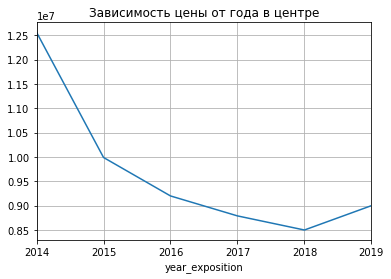

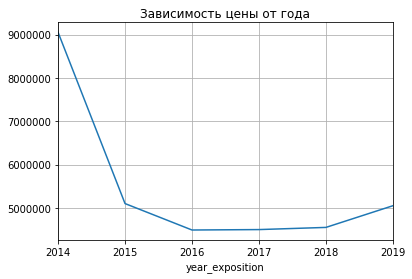

In [89]:
relation_year_price_for_centre = (
    df_centre.pivot_table(index='year_exposition', values='last_price', aggfunc=['median'])
)
relation_year_price_for_centre.plot(grid=True, legend=False, title='Зависимость цены от года в центре')
relation_year_price.plot(grid=True, legend=False, title='Зависимость цены от года')
print(df_centre['year_exposition'].value_counts())
print(df_centre['first_day_exposition'].max())
relation_year_price_for_centre

Графики похожи. Зависимость есть. Отличие в том, что в центре цена продолжала снижаться и после 2016 года, но уже не так сильно. И уже в 2018 году начался подъем.

### 5. Общий вывод<a id='5'></a>

Были изучены следующие параметры: площадь, цена, число комнат, высота потолков, этаж, удалённость от центра, дата размещения объявления.  

Самая высокая стоимость жилья среди популярных населенных пунктов в Санкт-Петербурге, самая низкая - в Выборге.  
Согласно данным по всей выборке чаще всего продавались квартиры с ценой 3-5 млн. В центре города данные другие, самые частые цены 5-9 млн.  
Чаще всего высота потолков около 2.6 м, а потолки выше 3.2 м почти не встречаются. Но в центре города потолки выше, и чаще встречается высота около 3 м.  
Квартиры на первом этаже - самые дешевые, дороже идут квартиры на последнем этаже, и самые дорогие расположены на средних этажах.  
Чаще всего продают квартиры с площадью от 40 до 70 метров. Также вне центра больше покупают квартиры с площадью до 40 метров, а в центре - от 70 до 100.  
Выделены категории продаж:
- до 45 дней - очень быстрая продажа,
- 45-232 дня - нормальная продажа,
- больше 232 дней - необычно долгая продажа  

Аномальные значения начинаются с 513 дней.  

Найдена прямая линейная зависимость цены от площади. Коэффициент 0,6.  
Найдена прямая линейная зависимость цены от числа комнат. Коэффициент 0,3.  
Найдена обратная линейная зависимость цены от удалённости от центра. Коэффициент -0,2.  
Зависимость цены от дня размещения объявления не найдена.  
Зависимость цены от месяца размещения объявления не найдена.  
Найдена зависимость цены от года размещения.